# 12. 인공지능으로 세상에 없던 새로운 모델 만들기

# ◈ 목표
`생성 모델링 개념을 이해`하며 `판별 모델링과의 차이` 알기 `Pix2Pix`, `CycleGAN` 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기 `Fashion MNIST 데이터셋의 의미`를 알기 `생성적 적대 신경망(GAN)의 구조와 원리를 이해`하기 텐서플로우로 짠 `DCGAN 학습 코드`를 익히며 응용하기

목차 없던 데이터를 만들어낸다, 생성 모델링 여러 가지 생성 모델링 기법과 친해지기 패션을 디자인하려면? 먼저 패션을 배워야지! 그림을 만들어내는 화가 생성자(Generator), 그리고 평가하는 비평가 구분자(Discriminator) 생성 모델이 똑똑해지기 위한 기나긴 여정

# ◈ 목차
Step 1. 라이브러리 import  
Step 2. 데이터셋 구성  
Step 3. 생성자 모델 구현  
Step 4. 판별자 모델 구현  
Step 5. 손실함수와 최적화함수 구현  
Step 6. 훈련과정 상세 기능 구현  
Step 7. 학습 과정 진행  
Step 8. (optional) GAN 훈련 과정 개선

# Step 1. 라이브러리 import

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


# Step 2. 데이터셋 구성
- CIFAR-10 데이터셋도 tf.keras안에 있는 datasets에 포함
- 학습에 사용할 ```train_x```의 이미지를 [-1, 1]로 정규화
- 로드한 학습 데이터를 시각화를 통해 확인
- tf.data.Dataset 모듈의 from_tensor_slices() 사용
- 미니배치 데이터셋을 구성  

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

## * 데이터 시각화
- 채널 정보 확인
    - MNIST, Fashioin MNIST의 경우 gray scale이라서 채널을 단순히 1만 추가해 주었음.
    - cifar10과 같은 경우 rgb, 3개의 채널이 존재

In [3]:
train_x[0].shape

(32, 32, 3)

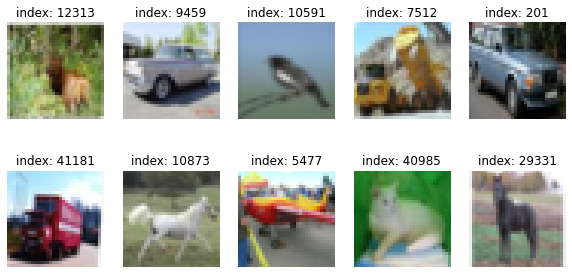

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    rn = np.random.randint(len(train_x))
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[rn])
    plt.title(f'index: {rn}')
    plt.axis('off')
# plt.imshow(train_x[0])
plt.show()

## * 데이터 정규화
- 데이터의 최댓값과 최솟값을 확인
- [-1, 1] 로 정규화
- index 3318의 폭격기의 사진을 정규화 후에 다시 한 번 시각화를 해본다.

In [5]:
train_x.max(), train_x.min()

(255, 0)

In [6]:
train_x = (train_x - 127.5) / 127.5

train_x.max(), train_x.min()

(1.0, -1.0)

In [7]:
train_x[3318].max(), train_x[3318].min()

(0.403921568627451, -1.0)

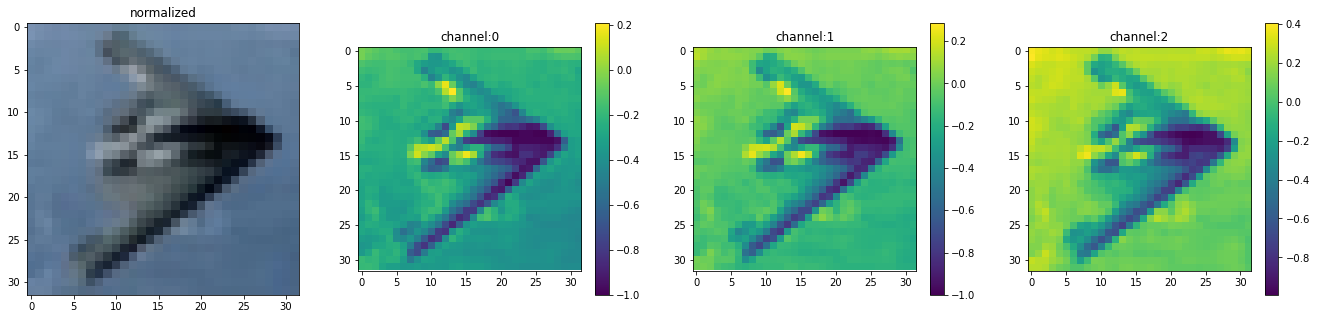

In [8]:
# 정규화 후에 시각화시도 및 채널별 출력
# imshow의 경우 음수의 값은 표현이 안된다고 경고문이 뜰 것이다.
# [-1, 1]의 범위를 다시 [0, 1]로 다시 변환
plt.figure(figsize=(23, 5))

plt.subplot(1, 4, 1)
plt.title("normalized")
plt.imshow((train_x[3318]+1)/2)

for i in range(3):
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(train_x[3318][:,:,i])
    plt.title('channel:{}'.format(i))
    plt.colorbar()
    
# plt.colorbar()
plt.show()

In [9]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 128

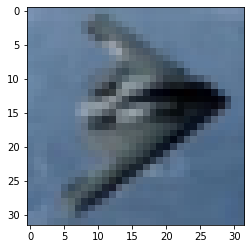

In [10]:
test_img = train_x[3318]
plt.imshow((test_img[:,:,:]+1) / 2)

In [11]:
test_img.shape

(32, 32, 3)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x, )
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

연산이 너무 오래걸려서 64로 ```Resize``` 

##### ```Resize```를 사용했을 때, 이미지의 변화를 시각화
1. ```next```와 ```iter```를 사용해서 train_dataset에서 부터 데이터를 꺼내보았다.
    - 이때 ```train_dataset```은 ```Resize```를 수행하기 전인 32x32 사이즈의 이미지이다.
2. 순서대로 32, 64, 128의 사진들
---
확실히 이미지의 픽셀사이즈는 줄고 경계가 부드러워 졌지만 여전히 뿌옇게 노이즈가 낀것 같이 육안으로 구분하기는 힘듦

In [13]:
test_img = next(iter(train_dataset))

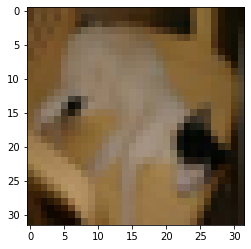

In [14]:
plt.imshow((test_img[0,:,:,:]+1)/2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



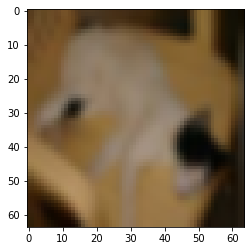

In [15]:
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64, interpolation='bilinear')(test_img)
plt.imshow((result1[0,:,:,:]+1)/2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



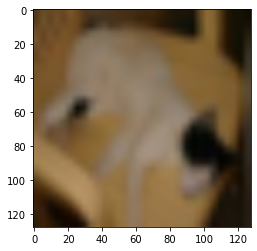

In [16]:
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(test_img)
plt.imshow((result2[0,:,:,:]+1)/2)

데이터셋의 사진들을 64로 사이즈를 ```Resize```를 시도하고 시각화를 해본다.  
기존의 32 x 32 이미지를 64 x 64로 사이즈를 키우고 보간법으로 bilinear를 사용했다. 

In [17]:
train_dataset = train_dataset.map(lambda x : tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(x))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



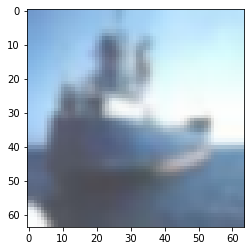

In [18]:
# 데이터셋을 만든 후 데이터 확인
check = next(iter(train_dataset))
plt.imshow((check[0]+1)/2)
plt.show()

# Step 3. 생성자 모델 구현
- (32, 32, 3)의  shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- ```noise = tf.random.normal([1, 100])```로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 본다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 본다.
---
### Fashion MNIST와 다른 점
- 흑백이미지가 아닌 컬러이미지이기 때문에 채널이 1 -> 3
- 사이즈또한 28x28이 아닌 64x64이기 때문에 다음과 같이 조정
    - 기존에 Desne층에 전해주는 (7 * 7 * 256)에서 7을 8로 조정
    - 추가적으로 Reshape층에 7을 8로 변환

In [19]:
INPUT_SHAPE = (64, 64, 3)

In [20]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Seventh: Conv2DTranspose layer
    # Color에는 rgb의 3개 채널이 있어야 하기 때문에 3으로 변경
#     model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), padding='same', use_bias=False, activation='tanh'))

    return model

In [21]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262144    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

(1, 64, 64, 3)
0.014198885 -0.017691992


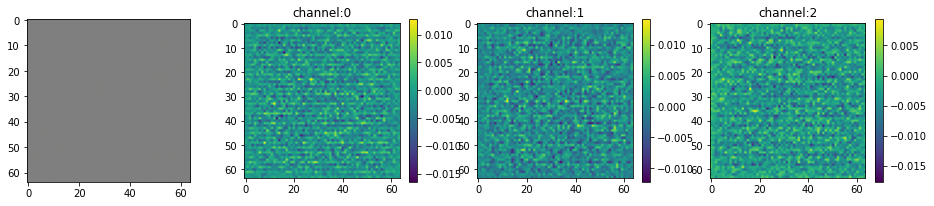

In [22]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
print(np.max(generated_image[0]), np.min(generated_image[0]))

plt.figure(figsize=(16, 3))
plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, :]+1)/2)
for i in range(3) :
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

# Step 4. 판별자 모델 구현
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별변과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- step 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 본다.

In [23]:
INPUT_SHAPE

(64, 64, 3)

In [24]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
#     Second : Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third : Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    # Fourth : Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [25]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)      

In [26]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00020517]], dtype=float32)>

# Step 5. 손실함수와 최적화함수 구현
- 생성자와 판별자의 손실함수(Loss)를 구현
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
- 생성자와 판별자를 최적화하는 optimizer를 정의

### 손실함수(loss function)정의
- loss는 ```BinaryCrossEntropy```사용
    - from _logist는 왜 True인가?
- ```gernerator```
    - 새로 만드는 이미지(fake_output)에 대한 
- ```discriminator```
    - ```discriminator```의 입장에서는 real은 진짜로, fake는 가짜로 판별하도록 학습해야 한다.
    - 두가지의 loss값을 같이 사용
        1. real_loss
            - real_loss는 1에 가까워져야 하기 때문에 ```tf.ones_like()```함수를 사용하여서 1과 real_output의 차이를 사용
        2. fake_loss
            - fake_loss는 0에 가까워야 한다. = discriminator 입장에서는 가짜를 가짜라고 판별해야 하기 때문
            - ```tf.zeros_like()``` 함수를 사용하여 0과 fake_output의 차이를 loss로 활용
            - total_loss는 두 개의 loss를 더해서 반환

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 정확도(accuracy) 반환 함수

In [30]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수 (Optimizer)
- Adam 활용
    - 참고자료를 확인해보면 ```lr```은 ```0.0002```가 적합하고 ```beta_1```의 수치는 ```0.5```로 주는 것이 좋다고 한다.
- 추가로 생각해볼 점
    - generator와 discriminator가 학습을 하는 곡선을 비교해보면 정확하게 반대로 학습을 하는 것은 아니다.
    - 학습률을 다르게 시작하고 에폭을 반복할 수록 loss값들을 활용 혹은 accuracy의 변동폭을 보면서 학습률을 능동적으로 조정을 해준다면?

In [31]:
# adam = 0.0002, beta_1=0.5

# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

# Step 6. 훈련과정 상세 기능 구현
- 1개 미니배치의 훈련 과정을 처리하는 ```train_step()``` 함수를 구현해 본다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 ```generate_and_save_images()```함수를 구현해 본다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 ```draw_train_history()``` 함수를 구현해 본다
- ```training_checkpoints``` 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 본다.

### 고정 seed 생성

In [32]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### ```train_step()``` 함수
- 이부분이 제일 이해하기 힘들다
- 1개의 미니배치 훈련 과정을 처리
- ```tf.GradientTape()``` : 가중치 갱신을 위한 Gradient를 자동미분으로 계산히기 위해서 with구문으로 연다

In [33]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator가 이미지를 생성
        generated_images = generator(noise, training=True)
        
        # discriminator가 실제 입력받은 이미지로는 real_output
        # 위에서 생성한 이미지에 대해서는 fake_output을 계산해서 return
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 real_output, fake_output 두 개를 받아서 연산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy계산해서 real, fake에 대한 accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # 이부분이 신기하다
    # gradient를 계산하는 부분, gen+tape와 disc_tape를 활용해서 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 위에서 계산된 optimzer에 입력해서 가중치를 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

### ```generate_and_save_images()```함수를 구현해 본다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 

In [34]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    # 이부분을 그려주는게 달라져야 할듯
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))
    
    plt.show()

### ```draw_train_history()``` 함수
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지파일로 저장한다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04}.png'
               .format(os.getenv("HOME"), epoch))
    plt.show()
    

### ```training_checkpoints``` 
- 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 본다.

In [36]:
checkpoint_dir = os.getenv("HOME") + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# Step 7. 학습 과정 진행
- 위 STEP 6에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 본다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해본다.
- 학습 과정을 담음 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출한다.  
<br> 

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생긴다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간낭비가 될 것이다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해둔 바 있다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요없이 이런 작업을 진행할 수 있다.  
아래는 checkpoint모듈을 활용하여 모델을 로드하는 예시
```python
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.
```
checkpoint를 통해 모델이 로드 되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있다.
```python
%%time
train(train_datset, EPOCHS, save_every)
```

In [37]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

In [38]:
save_every = 10
EPOCHS = 100

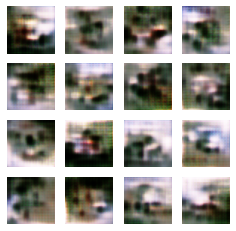

Epoch 10 | iter 151
Time for epoch 10 : 516 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

# Step 8. (optional) GAN 훈련 과정 개선
- step 7을 진행하면서 생성된 샘플이미지, 학습과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 본다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습과정 그래프 포함)를 함께 제출  
<br>  

(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것이다.
- https://github.com/soumith/ganhacks
- https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
- https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
- https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf

# ◈ 평가 항목
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
    
2. 생성이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.

3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

# ◈ 결과 및 고찰¶
실행 시간이 너무 오래 걸려서 끝까지 진행하기 힘들었다. 이 과제를 응용하여 어떻게 쓸 수 있는지 아직 감이 잡히지는 않는다. 